In this notebook:
- Generate samples of the cosmos convergence field
- Plot said samples
- Compare with DeepPosterior and Kaiser-Squires

In [1]:
import sys
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)

In [2]:
from typing import Tuple, Union
import numpy as np
import torch
import yaml
import types
import json

from data.lightning.MassMappingDataModule import MMDataModule
from models.lightning.mmGAN import mmGAN
from scipy import ndimage
from utils.mri.math import tensor_to_complex_np
import matplotlib.pyplot as plt

/home/jjwhit/rcGAN/fastmri/__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def normalize(
    data: torch.Tensor,
    mean: Union[float, torch.Tensor],
    stddev: Union[float, torch.Tensor],
    eps: Union[float, torch.Tensor] = 0.0,
) -> torch.Tensor:
    """
    Normalize the given tensor.

    Applies the formula (data - mean) / (stddev + eps).

    Args:
        data: Input data to be normalized.
        mean: Mean value.
        stddev: Standard deviation.
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        Normalized tensor.
    """
    return (data - mean) / (stddev + eps)


def normalize_instance(
    data: torch.Tensor, eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Normalize the given tensor  with instance norm/

    Applies the formula (data - mean) / (stddev + eps), where mean and stddev
    are computed from the data itself.

    Args:
        data: Input data to be normalized
        eps: Added to stddev to prevent dividing by zero.

    Returns:
        torch.Tensor: Normalized tensor
    """

    mean = data.mean()
    std = data.std()

    return normalize(data, mean, std, eps), mean, std

def normalise_complex(
    shear: torch.Tensor, #Shape (2, H, W) 
    mag_mean: float = 0.14049194898307577,
    mag_std: float = 0.11606233247891737,
    eps: Union[float, torch.Tensor] = 0.0
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    magnitude = torch.abs(torch.complex(shear[0,:,:], shear[1,:,:]))
    phase = torch.angle(torch.complex(shear[0,:,:], shear[1,:,:])) #In radians

    normal_mag = (magnitude - mag_mean) / (mag_std + eps)
    normal_shear = normal_mag * torch.exp(1j*phase)
    normal_real = normal_shear.real
    normal_imag = normal_shear.imag
    return torch.stack((normal_real, normal_imag)), mag_mean, mag_std

def unnormalize_complex(
    normed_data: torch.Tensor, 
    mag_mean: float = 0.14049194898307577, 
    mag_std: float = 0.11606233247891737,
):
    normed_mag = torch.abs(torch.complex(normed_data[0,:,:], normed_data[1,:,:]))
    phase = torch.angle(torch.complex(normed_data[0,:,:], normed_data[1,:,:]))
    # mag_data = ((normed_data * mag_std) / torch.exp(1j*phase)) + mag_mean
    # unnormed_data_real = mag_data * torch.cos(phase)
    # unnormed_data_imag = mag_data * torch.sin(phase)

    unnormed_mag = (normed_mag * mag_std) + mag_mean
    unnormed_data = unnormed_mag * torch.exp(1j*phase)
    unnormed_data_real = unnormed_data.real
    unnormed_data_imag = unnormed_data.imag
    return torch.stack((unnormed_data_real, unnormed_data_imag))

In [5]:
def compute_fourier_kernel(N: int) -> np.ndarray:
    """Computes the Fourier space kernel which represents the mapping between 
        convergence (kappa) and shear (gamma).

    Args:
        N (int): x,y dimension of image patch (assumes square images).

    Returns:
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
    """
    # Generate grid of Fourier domain
    kx = np.arange(N).astype(np.float64) - N/2
    kx, ky = np.meshgrid(kx, kx)
    k = kx**2 + ky**2
    # Define Kaiser-Squires kernel
    D = np.zeros((N, N), dtype=np.complex128)
    #D = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, D)
    # Another formulation to avoid divide by zero warning
    D[k>0] = (((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))[k>0]/k[k>0])
    # Apply inverse FFT shift 
    return np.fft.ifftshift(D)

def forward_model(kappa: np.ndarray, D: np.ndarray) -> np.ndarray:
    """Applies the forward mapping between convergence and shear through their 
        relationship in Fourier space.

    Args:
        kappa (np.ndarray): Convergence field, with shape [N,N].
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].

    Returns:
        gamma (np.ndarray): Shearing field, with shape [N,N].
    """
    F_kappa = np.fft.fft2(kappa) # Perform 2D forward FFT
    F_gamma = F_kappa * D # Map convergence onto shear
    return np.fft.ifft2(F_gamma) # Perform 2D inverse FFT
def realistic_noise_maker(kappa: np.ndarray) -> np.ndarray:
    """Adds realistic simulated Gaussian noise to a mock weak lensing map.

    Args:
        im_size (int): Size of weak lensing map, in pixels.
        kappa (np.ndarray): Convergence map.
    
    Returns:
        gamma (np.ndarray): A synthetic representation of the shear field, gamma, with added noise.
    """
    im_size=300
    D = compute_fourier_kernel(im_size) #Fourier kernel
    gamma = forward_model(kappa, D) + (
        std1 * np.random.randn(im_size, im_size) 
        + 1.j * std2 * np.random.randn(im_size, im_size)
    )
    return gamma

In [6]:
# Loads the cosmos shear, and components needed to generate a mock shear map (model works best with a batch size >1 so we will generate a second map to pass through the model.)
mask = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True)
std1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std1.npy', allow_pickle=True)
std2 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_std2.npy', allow_pickle=True)
test_tensor_1 = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_shear_cropped.npy', allow_pickle=True)
test_tensor_2 = np.load('/share/gpu0/jjwhit/kappa_cosmos_simulations/cropped_dataset/kappa_val/cropped_sim_08985.npy', allow_pickle=True)
kappa_mean = 0.00015744006243248638
kappa_std  = 0.02968584954283938

In [7]:
# Should be complex64
test_tensor_1.dtype

dtype('complex64')

In [8]:
# Turns the mock convergence map into a mock shear map
test_tensor_2 = realistic_noise_maker(test_tensor_2)

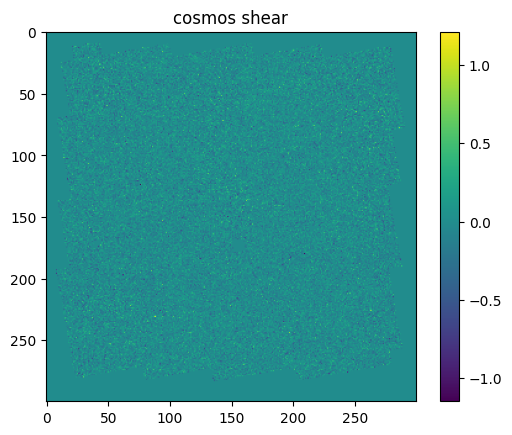

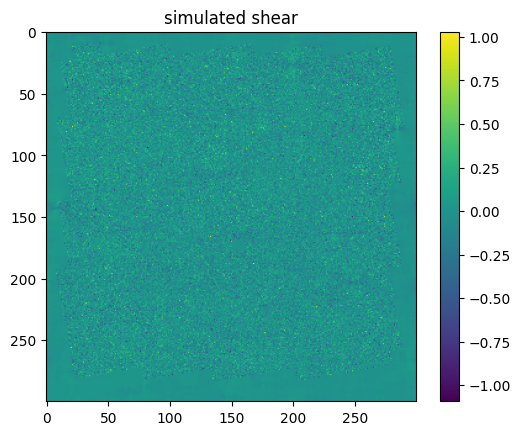

In [11]:
# Checking the mock map is comparable to the cosmos shear map
plt.imshow(test_tensor_1.real)
plt.colorbar()
plt.title('cosmos shear')
plt.show()
plt.imshow(test_tensor_2.real)
plt.colorbar()
plt.title('simulated shear')
plt.show()

In [12]:
test_tensor = np.stack((test_tensor_1, test_tensor_2), axis=0)
test_tensor = np.stack((test_tensor.real, test_tensor.imag), axis=-1)

In [13]:
# Expecting (2,300,300,2)
test_tensor.shape

(2, 300, 300, 2)

In [14]:
test_tensor = torch.tensor(test_tensor).cuda()

In [15]:
normalised_gamma, mean, std = normalise_complex(test_tensor)
normalised_gamma[:, mask==0] = 0
normalised_gamma = normalised_gamma.permute(0,3,1,2).float()

In [16]:
# Expecting [2, 2, 300, 300]
normalised_gamma.shape

torch.Size([2, 2, 300, 300])

With data prep done, will now pass through the GAN to generate samples

In [17]:
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [18]:
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint(
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_long/checkpoint-epoch=276.ckpt') 
        # Currently manually loading desired epoch rather than 'best' epoch

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [19]:
gens_mmGAN = torch.zeros(size=(2,32, 300,300, 2)).cuda()
with torch.no_grad():
    print(mmGAN_model.forward(normalised_gamma).shape)
    for z in range(32):
        gens_mmGAN[:,z, :, :, :] = mmGAN_model.reformat(mmGAN_model.forward(normalised_gamma))

torch.Size([2, 2, 300, 300])


In [20]:
# Expecting [2, 32, 300, 300, 2]
gens_mmGAN.shape

torch.Size([2, 32, 300, 300, 2])

In [21]:
avg_mmGAN = torch.mean(gens_mmGAN, dim=1)

In [22]:
# Formats the samples, reconstruction, and standard deviation

np_avgs_sim = {
    'mmGAN': None,
}

np_samps_sim = {
    'mmGAN': [],
}

np_stds_sim = {
    'mmGAN': None,
}


np_avgs_sim['mmGAN'] = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((avg_mmGAN[1] * kappa_std + kappa_mean).cpu())).numpy(),
    180)
for z in range(32):
    np_samps_sim['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[1, z] * kappa_std + kappa_mean).cpu())).numpy(), 180))

np_stds_sim['mmGAN'] = np.std(np.stack(np_samps_sim['mmGAN']), axis=0)

np_avgs_cos = {
    'mmGAN': None,
}

np_samps_cos = {
    'mmGAN': [],
}

np_stds_cos = {
    'mmGAN': None,
}


np_avgs_cos['mmGAN'] = ndimage.rotate(
    torch.tensor(tensor_to_complex_np((avg_mmGAN[0] * kappa_std + kappa_mean).cpu())).numpy(),
    180)
for z in range(32):
    np_samps_cos['mmGAN'].append(ndimage.rotate(torch.tensor(
        tensor_to_complex_np((gens_mmGAN[0, z] * kappa_std + kappa_mean).cpu())).numpy(), 180))

np_stds_cos['mmGAN'] = np.std(np.stack(np_samps_cos['mmGAN']), axis=0)

In [23]:
np.save('/share/gpu0/jjwhit/samples/epoch-276/np_avgs_cos.npy', np_avgs_cos['mmGAN'])
np.save('/share/gpu0/jjwhit/samples/epoch-276/np_stds_cos.npy', np_stds_cos['mmGAN'])
np.save('/share/gpu0/jjwhit/samples/epoch-276/np_samps_cos.npy', np_samps_cos['mmGAN'])

Moving on to plotting...

In [ ]:
# Skip these imports you've run the above cells - these are repeats
import sys
dir = '/home/jjwhit/rcGAN/'
sys.path.append(dir)

import torch
import yaml
import types
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from data.lightning.MassMappingDataModule import MMDataModule
from models.lightning.mmGAN import mmGAN
from utils.mri.math import tensor_to_complex_np

In [24]:
# These are not repeats
import matplotlib.patches as patches
from utils.mri import transforms
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tkr
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenspack.geometry.projections import gnom
from data.lightning.MassMappingDataModule import MMDataTransform
from mass_map_utils.scripts.ks_utils import backward_model

In [ ]:
# Also skip these cells if you've run the previous section, skip to the next cell without the 'repeat' comment
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# repeat
def load_object(dct):
    return types.SimpleNamespace(**dct)

In [ ]:
# repeat
torch.set_float32_matmul_precision('medium')

with open(dir+'configs/mass_map.yml', 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    cfg = json.loads(json.dumps(cfg), object_hook=load_object)

dm = MMDataModule(cfg)
fig_count = 1
dm.setup()
test_loader = dm.test_dataloader()

with torch.no_grad():
    mmGAN_model = mmGAN.load_from_checkpoint( 
        checkpoint_path='/share/gpu0/jjwhit/mass_map/mm_models/mmgan_training_3/checkpoint-epoch=98.ckpt')
    # Manualling loading desired checkpoint, usually is set to best epoch.

    mmGAN_model.cuda()

    mmGAN_model.eval()

In [25]:
# Setting up edges of COSMOS survey
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

In [26]:
# So we can plot in terms of position on the sky
def get_extend_radec(res, width):
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size = res #arcmin
    dx = np.deg2rad(width*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [36]:
np_avgs = {
    'mmGAN': None,
}

np_samps = {
    'mmGAN': [],
}

np_stds = {
    'mmGAN': None,
}

np_avgs['mmGAN'] = np.load('/share/gpu0/jjwhit/samples/epoch-276/np_avgs_cos.npy')
np_stds['mmGAN'] = np.load('/share/gpu0/jjwhit/samples/epoch-276/np_stds_cos.npy')
np_samps['mmGAN'] = np.load('/share/gpu0/jjwhit/samples/epoch-276/np_samps_cos.npy')

mask = np.load('/home/jjwhit/rcGAN/mass_map_utils/cosmos/cosmos_mask.npy', allow_pickle=True)
std1 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std1.npy', allow_pickle=True
)
std2 = np.load(
    cfg.cosmo_dir_path + 'cosmos_std2.npy', allow_pickle=True
)
xclusters = np.loadtxt("/home/jjwhit/rcGAN//mass_map_utils/cosmos/xray.txt")
m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)

In [31]:
method = 'mmGAN'
contours = find_contours(mask, 0.5)
outer_contour = max(contours, key=lambda x: x.shape[0])
width = 300
resolution = 0.29

In [32]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/tmp/ipykernel_121040/3286024878.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_121040/3286024878.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


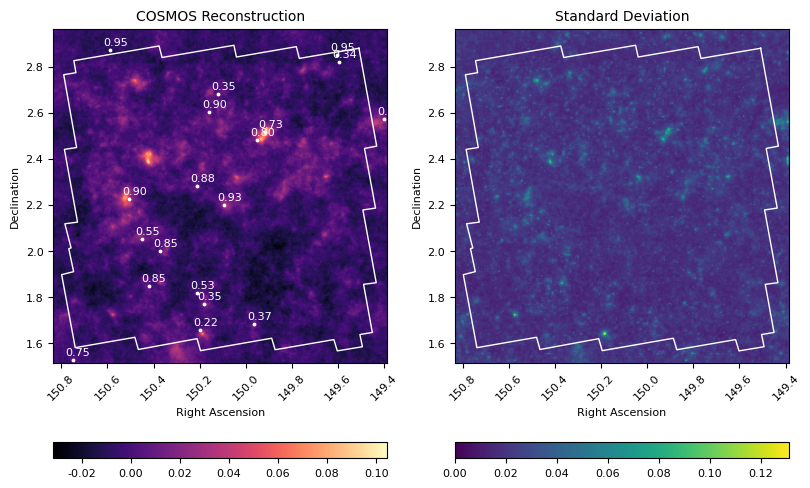

In [39]:
# COSMOS reconstruction plus standard deviation, overlayed with xray data


nrow = 1
ncol = 2
width = 300
resolution = 0.29

fig, axes = plt.subplots(nrow, ncol, figsize=(8,5), constrained_layout=True)

ra, dec = np.array(COSMOS_VERTICES).T
axes[0].plot(ra,dec,c='w',lw=1)

rotated_img = ndimage.rotate(np_avgs[method], 270)
rotated_img = np.flipud(rotated_img)
im1 = axes[0].imshow(rotated_img.real, cmap='magma', vmin=np.min(rotated_img.real), vmax=np.max(np_avgs[method].real),
                     origin='lower',extent=get_extend_radec(resolution,  width), aspect='auto')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_title('COSMOS Reconstruction')
axes[0].set_xlabel('Right Ascension')
axes[0].set_ylabel('Declination')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
plt.colorbar(im1, ax=axes[0], shrink=1, orientation='horizontal',format=tkr.FormatStrFormatter('%.2f'))

highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        axes[0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')


axes[1].plot(ra,dec,c='w',lw=1)
rotated_sd = ndimage.rotate(np_stds[method].real, 270)
rotated_sd = np.flipud(rotated_sd)
im3 = axes[1].imshow(rotated_sd, cmap='viridis', vmin=0, vmax=np.max(np_stds['mmGAN']), origin='lower',
                     extent=get_extend_radec(resolution,  width), aspect='auto')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_title('Standard Deviation')
axes[1].set_xlabel('Right Ascension')
axes[1].set_ylabel('Declination')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.colorbar(im3, ax=axes[1], shrink=1, orientation='horizontal', format=tkr.FormatStrFormatter('%.2f'))

# plt.show()
plt.savefig(f'/share/gpu0/jjwhit/plots/epoch-276/cosmos_results.png', bbox_inches='tight', dpi=300)

In [40]:
# Load the DeepPosterior cosmos reconstruction
cosmos_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_mean_hdu.fits')
start_row = (cosmos_dlp.shape[0] - 300) // 2
start_col = (cosmos_dlp.shape[1] - 300) // 2

# Extract the center 300x300 portion to match with out reconstruction size
cosmos_dlp_resized = cosmos_dlp[start_row:start_row + 300, start_col:start_col + 300]

# Cosmos mean/UQ
cosmos_samps_dlp = fits.getdata('/share/gpu0/jjwhit/remy2022_results/cosmos/dlp_cosmos_samples_hdu.fits')
dlp_std = cosmos_samps_dlp[:,...].std(axis=0)

In [43]:
# Creating a Kaiser-Squires reconstruction

D = MMDataTransform.compute_fourier_kernel(cfg.im_size)
cropped_cosmos_shear = np.load(dir+'mass_map_utils/cosmos/cosmos_shear_cropped.npy', allow_pickle=True)
cropped_kernel = MMDataTransform.compute_fourier_kernel(300)

In [44]:
vmin = np.min(np_avgs[method].real)
vmax = np.max(np_avgs[method].real)

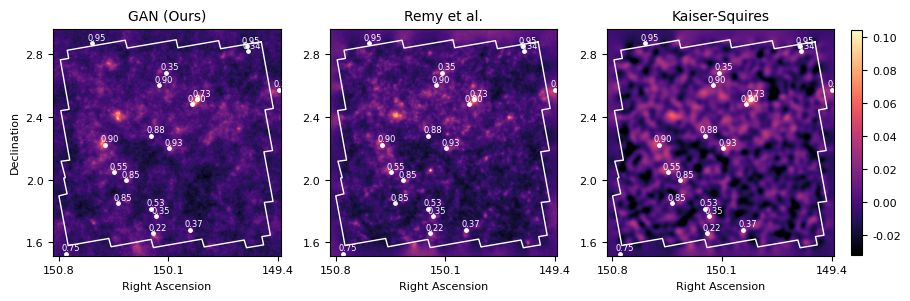

In [56]:
nrow = 1
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(9,3), constrained_layout=True)

x_ticks = [150.8, 150.1, 149.4]
y_ticks = [2.8, 2.4, 2.0, 1.6]

axes[0].plot(ra,dec,c='w',lw=1)
rotated_img = ndimage.rotate(np_avgs[method], 270)
im1 = axes[0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                     extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[0].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=0.75)
axes[0].set_title('GAN (Ours)')
axes[0].invert_xaxis()
axes[0].set_aspect('equal')
axes[0].set_xlabel('Right Ascension')
axes[0].set_ylabel('Declination')

for cluster in xclusters[highz]:
   ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
   m500 = cluster[7]
   if m500 > m500min:
       axes[0].scatter(ra_cl, dec_cl, c='w', s=6)
       axes[0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=6, c='w')

axes[1].plot(ra,dec,c='w',lw=1)
flipped_img = np.flipud(cosmos_dlp_resized)
im3 = axes[1].imshow(flipped_img, cmap='magma', vmin=vmin, vmax=vmax,
                    extent=get_extend_radec(resolution,  width), aspect='auto')
#axes[1].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[1].set_title('Remy et al.')
axes[1].invert_xaxis()
axes[1].set_aspect('equal')
axes[1].set_xlabel('Right Ascension')
# axes[1].set_ylabel('Declination')

for cluster in xclusters[highz]:
   ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
   m500 = cluster[7]
   if m500 > m500min:
       axes[1].scatter(ra_cl, dec_cl, c='w', s=6)
       axes[1].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=6, c='w')


cosmos_ks = backward_model(cropped_cosmos_shear, cropped_kernel)
cosmos_smoothed = np.flipud(ndimage.gaussian_filter(cosmos_ks, sigma=1/.29))

axes[2].plot(ra,dec,c='w',lw=1)
im4 = axes[2].imshow(cosmos_smoothed.real, cmap='magma', vmin=vmin, vmax=vmax,
                    extent=get_extend_radec(resolution,  width), aspect='auto') #TODO: Temp
#axes[2].plot(outer_contour[:, 1], outer_contour[:, 0], color='white', linewidth=1)
axes[2].set_title('Kaiser-Squires')
axes[2].invert_xaxis()
axes[2].set_aspect('equal')
axes[2].set_xlabel('Right Ascension')
# axes[2].set_ylabel('Declination')

for cluster in xclusters[highz]:
   ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
   m500 = cluster[7]
   if m500 > m500min:
       axes[2].scatter(ra_cl, dec_cl, c='w', s=6)
       axes[2].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=6, c='w')

# cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.015, shrink=0.8,
#                      format=tkr.FormatStrFormatter('%.2f'))
# cbar1.mappable.set_clim(vmin, vmax)
# cbar2 = fig.colorbar(im3, ax=axes[1], orientation='vertical', pad=0.015, shrink=0.8, 
#                      format=tkr.FormatStrFormatter('%.2f'))
# cbar2.mappable.set_clim()
cbar3 = fig.colorbar(im4, ax=axes[2], orientation='vertical', pad=0.015, shrink=0.84, 
                     format=tkr.FormatStrFormatter('%.2f'))
cbar3.mappable.set_clim()

for i in range(3):
    axes[i].set_xticks(x_ticks)
    axes[i].set_yticks(y_ticks)


# plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/epoch-276/cosmos_comparison_xray.png', bbox_inches='tight', dpi=300)

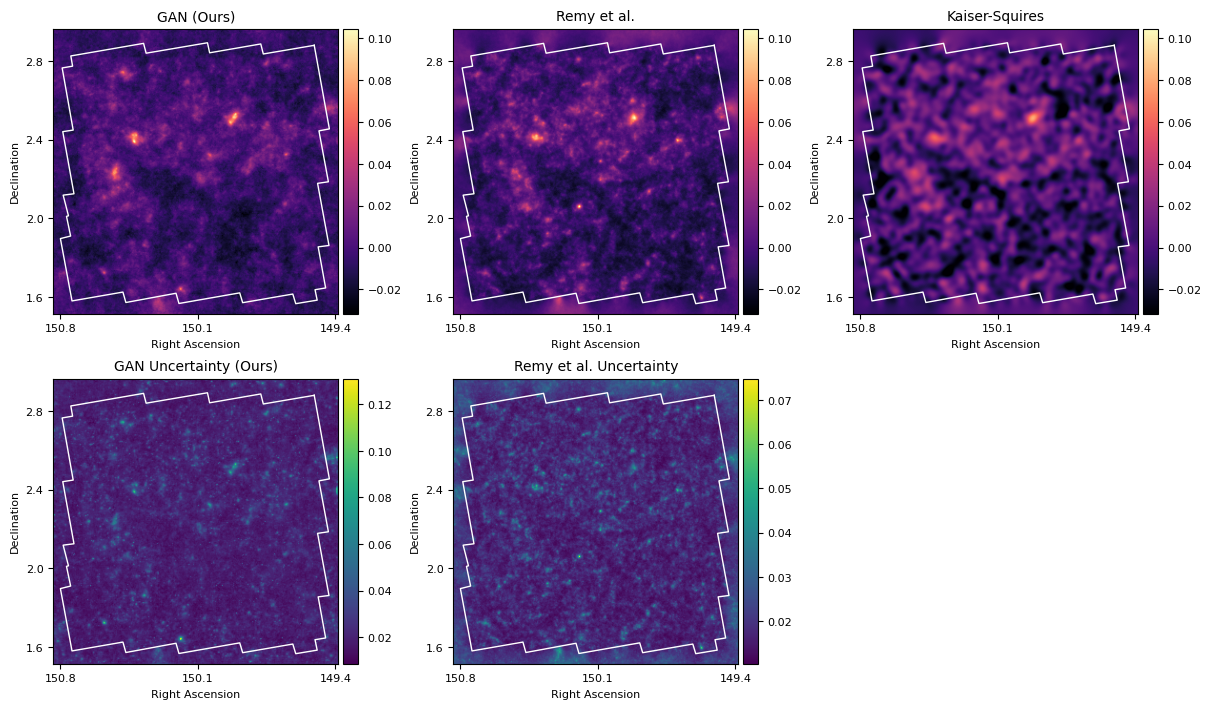

In [58]:
# Main horizontal plot
fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

x_ticks = [150.8, 150.1, 149.4]
y_ticks = [2.8, 2.4, 2.0, 1.6]

rotated_img = ndimage.rotate(np_avgs[method], 270)
axes[0, 0].plot(ra, dec, c='w', lw=1)
im1 = axes[0, 0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 0].set_title('GAN (Ours)')
axes[0, 0].invert_xaxis()
axes[0, 0].set_aspect('equal')
axes[0, 0].set_ylabel('Declination')
axes[0, 0].set_xlabel('Right Ascension')

# Plot 2: Deep Posterior
axes[0, 1].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(cosmos_dlp_resized)
im2 = axes[0, 1].imshow(flipped_img, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 1].set_title('Remy et al.')
axes[0, 1].invert_xaxis()
axes[0, 1].set_aspect('equal')
axes[0, 1].set_ylabel('Declination')
axes[0, 1].set_xlabel('Right Ascension')

# Plot 3: Kaiser-Squires
axes[0, 2].plot(ra, dec, c='w', lw=1)
cosmos_ks = backward_model(cropped_cosmos_shear, cropped_kernel)
cosmos_smoothed = np.flipud(ndimage.gaussian_filter(cosmos_ks, sigma=1/.29))
im3 = axes[0, 2].imshow(cosmos_smoothed.real, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 2].set_title('Kaiser-Squires')
axes[0, 2].invert_xaxis()
axes[0, 2].set_aspect('equal')
axes[0, 2].set_xlabel('Right Ascension')
axes[0, 2].set_ylabel('Declination')

# Plot 4: GAN Uncertainty
axes[1, 0].plot(ra, dec, c='w', lw=1)
rotated_img = ndimage.rotate(np_stds[method], 270)
im4 = axes[1, 0].imshow(rotated_img.real, cmap='viridis', vmin=np.min(np_stds[method]), vmax=np.max(np_stds[method]),
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 0].set_title('GAN Uncertainty (Ours)')
axes[1, 0].invert_xaxis()
axes[1, 0].set_aspect('equal')
axes[1, 0].set_xlabel('Right Ascension')
axes[1, 0].set_ylabel('Declination')

# Plot 5: Deep Posterior Uncertainty
axes[1, 1].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(dlp_std[30:330, 30:330])
im5 = axes[1, 1].imshow(flipped_img, cmap='viridis',
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 1].set_title('Remy et al. Uncertainty')
axes[1, 1].invert_xaxis()
axes[1, 1].set_aspect('equal')
axes[1, 1].set_xlabel('Right Ascension')
axes[1, 1].set_ylabel('Declination')

axes[1, 2].axis('off')

divider1 = make_axes_locatable(axes[0, 0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
divider2 = make_axes_locatable(axes[0, 1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax2)
divider3 = make_axes_locatable(axes[0, 2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = fig.colorbar(im3, cax=cax3)
divider4 = make_axes_locatable(axes[1, 0])
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = fig.colorbar(im4, cax=cax4)
divider5 = make_axes_locatable(axes[1,1])
cax5 = divider5.append_axes("right", size="5%", pad=0.05)
cbar5 = fig.colorbar(im5, cax=cax5)
for ax_row in axes:
    for ax in ax_row:
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
# plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/epoch-276/cosmos_uq_horizontal.png', bbox_inches='tight', dpi=300)

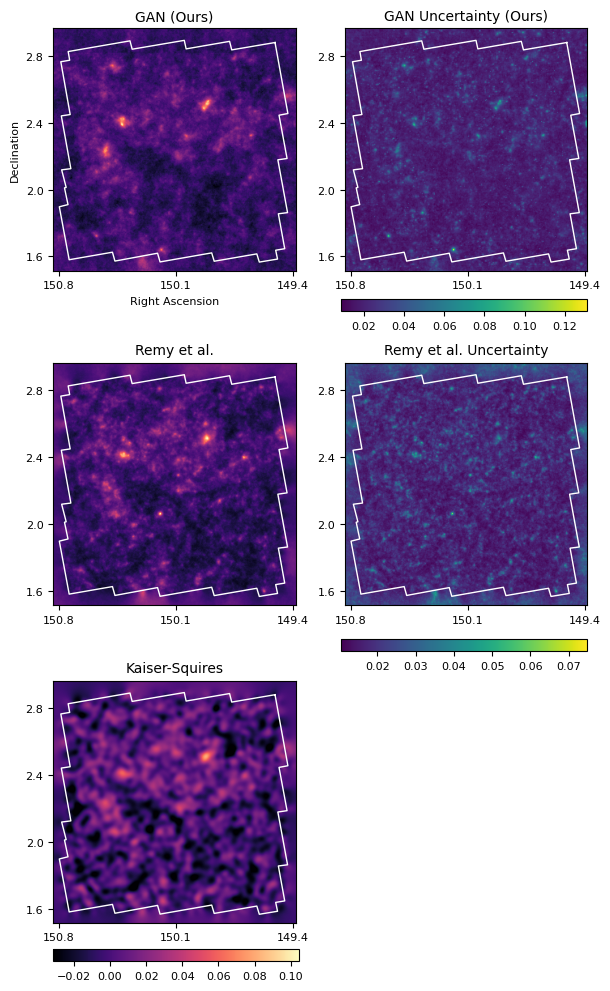

In [61]:
# Main vertical plot
fig, axes = plt.subplots(3, 2, figsize=(6, 9.7), constrained_layout=True)

x_ticks = [150.8, 150.1, 149.4]
y_ticks = [2.8, 2.4, 2.0, 1.6]

rotated_img = ndimage.rotate(np_avgs[method], 270)
axes[0, 0].plot(ra, dec, c='w', lw=1)
im1 = axes[0, 0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 0].set_title('GAN (Ours)')
axes[0, 0].invert_xaxis()
axes[0, 0].set_aspect('equal')
axes[0, 0].set_ylabel('Declination')
axes[0, 0].set_xlabel('Right Ascension')

# Plot 2: Deep Posterior
axes[1, 0].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(cosmos_dlp_resized)
im2 = axes[1, 0].imshow(flipped_img, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 0].set_title('Remy et al.')
axes[1, 0].invert_xaxis()
axes[1, 0].set_aspect('equal')
# axes[1, 0].set_ylabel('Declination')

# Plot 3: Kaiser-Squires
axes[2, 0].plot(ra, dec, c='w', lw=1)
cosmos_ks = backward_model(cropped_cosmos_shear, cropped_kernel)
cosmos_smoothed = np.flipud(ndimage.gaussian_filter(cosmos_ks, sigma=1/.29))
im3 = axes[2, 0].imshow(cosmos_smoothed.real, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[2, 0].set_title('Kaiser-Squires')
axes[2, 0].invert_xaxis()
axes[2, 0].set_aspect('equal')
# axes[2, 0].set_xlabel('Right Ascension')
# axes[2, 0].set_ylabel('Declination')

# Plot 4: GAN Uncertainty
axes[0, 1].plot(ra, dec, c='w', lw=1)
rotated_img = ndimage.rotate(np_stds[method], 270)
im4 = axes[0, 1].imshow(rotated_img.real, cmap='viridis', vmin=np.min(np_stds[method]), vmax=np.max(np_stds[method]),
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 1].set_title('GAN Uncertainty (Ours)')
axes[0, 1].invert_xaxis()
axes[0, 1].set_aspect('equal')
# axes[0, 1].set_xlabel('Right Ascension')
# axes[0, 1].set_ylabel('Declination')

# Plot 5: Deep Posterior Uncertainty
axes[1, 1].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(dlp_std[30:330, 30:330])
im5 = axes[1, 1].imshow(flipped_img, cmap='viridis',
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 1].set_title('Remy et al. Uncertainty')
axes[1, 1].invert_xaxis()
axes[1, 1].set_aspect('equal')
# axes[1, 1].set_xlabel('Right Ascension')

axes[2, 1].axis('off')

cax3 = fig.add_axes([0.08, 0, 0.41, 0.0125]) 
cbar3 = fig.colorbar(im3, ax=axes[2,0], orientation='horizontal', cax=cax3)
# cbar3.set_ticks([-0.04, 0.02, 0.08, 0.14])
cax4 = fig.add_axes([0.56, 0.67, 0.41, 0.0125]) 
cbar4 = fig.colorbar(im4, ax=axes[0,1], orientation='horizontal', cax=cax4)
# cbar4.set_ticks([0.02, 0.06, 0.1, 0.13])
cax5 = fig.add_axes([0.56, 0.32, 0.41, 0.0125])
cbar5 = fig.colorbar(im5, ax=axes[1,1], orientation='horizontal', cax=cax5)
# cbar5.set_ticks([0.01, 0.03, 0.05, 0.07])

for ax_row in axes:
    for ax in ax_row:
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
# plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/epoch-276/cosmos_uq_comparison_contoured.png', bbox_inches='tight', dpi=300)

Calculating the relative uncertainty between the GAN reconstruction and the Remy reconstruction:

In [62]:
num = ndimage.rotate(np_avgs[method], 270).real - np.flipud(cosmos_dlp_resized)
denom = np.sqrt((np.flipud(ndimage.rotate(np_stds[method].real, 270)))**2 + (np.flipud(dlp_std[30:330, 30:330]))**2)
relative_uncertainty = num/denom

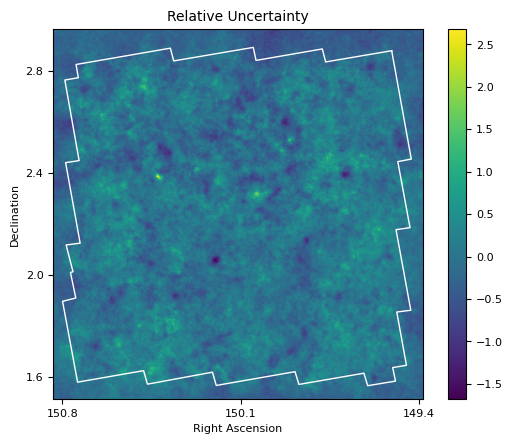

In [63]:
x_ticks = [150.8, 150.1, 149.4]
y_ticks = [2.8, 2.4, 2.0, 1.6]
plt.plot(ra,dec,c='w',lw=1)
plt.imshow(relative_uncertainty,extent=get_extend_radec(resolution,  width))
plt.colorbar()
plt.xlim(plt.xlim()[::-1])
plt.title('Relative Uncertainty')
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

plt.show()
# plt.savefig('/share/gpu0/jjwhit/plots/final_2/rel_uq.png', bbox_inches='tight', dpi=300)

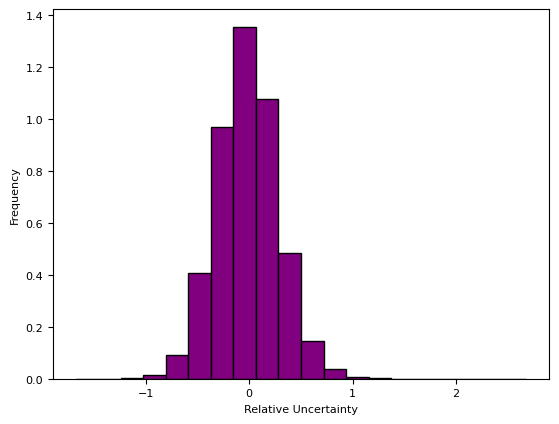

In [64]:
data_1d = relative_uncertainty.flatten()

plt.hist(data_1d, bins=20, color='purple', edgecolor='black', density=True)
plt.ylabel('Frequency')
plt.xlabel('Relative Uncertainty')

plt.show()
# plt.savefig('/share/gpu0/jjwhit/plots/final_2/rel_uq_hist.png', bbox_inches='tight', dpi=300)

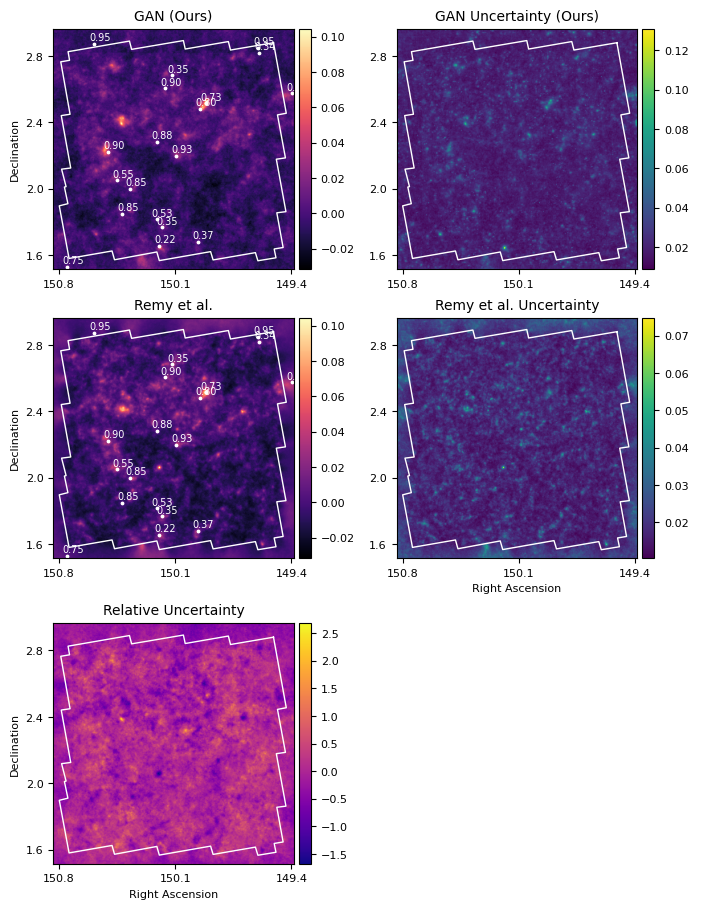

In [68]:
# Vertical figure
fig, axes = plt.subplots(3, 2, figsize=(7, 9), constrained_layout=True)

x_ticks = [150.8, 150.1, 149.4]
y_ticks = [2.8, 2.4, 2.0, 1.6]

rotated_img = ndimage.rotate(np_avgs[method], 270)
im1 = axes[0, 0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 0].plot(ra, dec, c='w', lw=1)
axes[0, 0].set_title('GAN (Ours)')
axes[0, 0].invert_xaxis()
axes[0, 0].set_aspect('equal')
axes[0, 0].set_ylabel('Declination')

# Plot 2: Deep Posterior
axes[1, 0].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(cosmos_dlp_resized)
im2 = axes[1, 0].imshow(flipped_img, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 0].set_title('Remy et al.')
axes[1, 0].invert_xaxis()
axes[1, 0].set_aspect('equal')
axes[1, 0].set_ylabel('Declination')

# Plot 3: Kaiser-Squires
axes[2, 0].plot(ra, dec, c='w', lw=1)
im3 = axes[2, 0].imshow(relative_uncertainty, cmap='plasma',
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[2, 0].set_title('Relative Uncertainty')
axes[2, 0].invert_xaxis()
axes[2, 0].set_aspect('equal')
axes[2, 0].set_xlabel('Right Ascension')
axes[2, 0].set_ylabel('Declination')

# Plot 4: GAN Uncertainty
axes[0, 1].plot(ra, dec, c='w', lw=1)
rotated_img = ndimage.rotate(np_stds[method], 270)
im4 = axes[0, 1].imshow(rotated_img.real, cmap='viridis', vmin=np.min(np_stds[method]), vmax=np.max(np_stds[method]),
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 1].set_title('GAN Uncertainty (Ours)')
axes[0, 1].invert_xaxis()
axes[0, 1].set_aspect('equal')
# axes[0, 1].set_xlabel('Right Ascension')
# axes[0, 1].set_ylabel('Declination')

# Plot 5: Deep Posterior Uncertainty
axes[1, 1].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(dlp_std[30:330, 30:330])
im5 = axes[1, 1].imshow(flipped_img, cmap='viridis',
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 1].set_title('Remy et al. Uncertainty')
axes[1, 1].invert_xaxis()
axes[1, 1].set_aspect('equal')
axes[1, 1].set_xlabel('Right Ascension')

axes[2, 1].axis('off')

m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        axes[0,0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[0,0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=7, c='w')
        axes[1,0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[1,0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=7, c='w')


# Define the colorbars using make_axes_locatable
divider1 = make_axes_locatable(axes[0, 0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
divider2 = make_axes_locatable(axes[1,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax2)
divider3 = make_axes_locatable(axes[2,0])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = fig.colorbar(im3, cax=cax3)
divider4 = make_axes_locatable(axes[0, 1])
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = fig.colorbar(im4, cax=cax4)
divider5 = make_axes_locatable(axes[1,1])
cax5 = divider5.append_axes("right", size="5%", pad=0.05)
cbar5 = fig.colorbar(im5, cax=cax5)

for ax_row in axes:
    for ax in ax_row:
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
# plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/epoch-276/cosmos_rel_uq_unbounded.png', bbox_inches='tight', dpi=300)

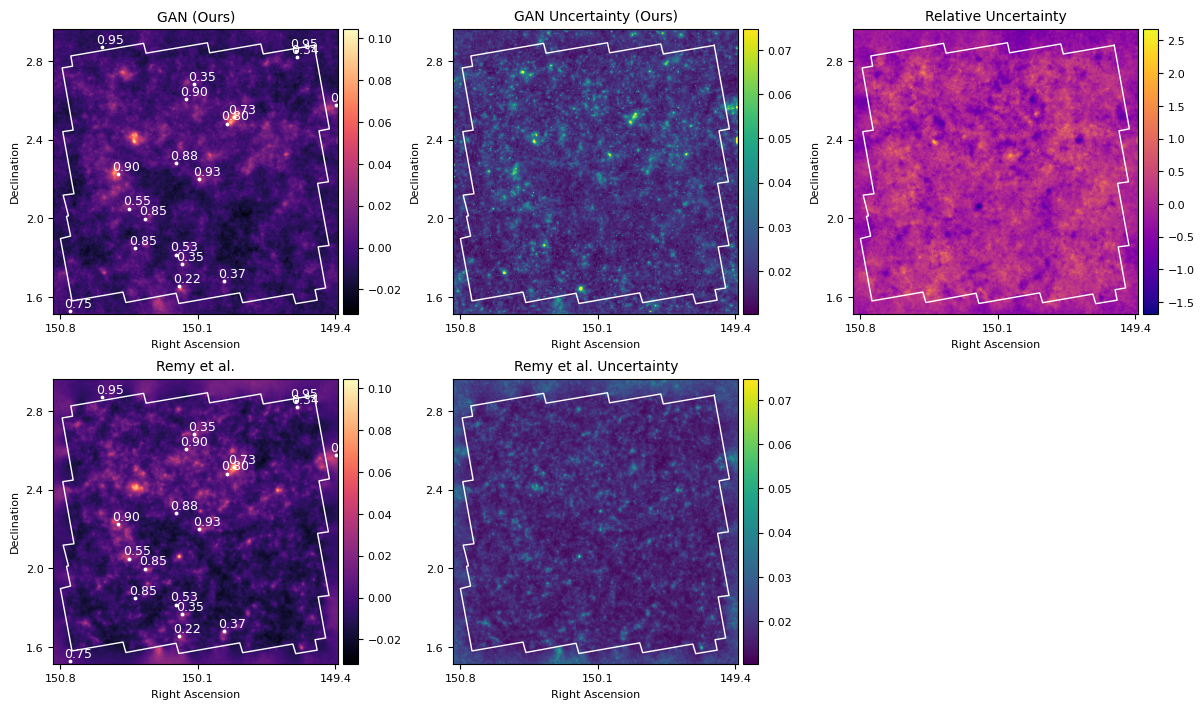

In [70]:
# Horizontal figure

fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

x_ticks = [150.8, 150.1, 149.4]
y_ticks = [2.8, 2.4, 2.0, 1.6]

rotated_img = ndimage.rotate(np_avgs[method], 270)
im1 = axes[0, 0].imshow(rotated_img.real, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 0].plot(ra, dec, c='w', lw=1)
axes[0, 0].set_title('GAN (Ours)')
axes[0, 0].invert_xaxis()
axes[0, 0].set_aspect('equal')
axes[0, 0].set_ylabel('Declination')
axes[0, 0].set_xlabel('Right Ascension')

# Plot 2: Deep Posterior
axes[1, 0].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(cosmos_dlp_resized)
im2 = axes[1, 0].imshow(flipped_img, cmap='magma', vmin=vmin, vmax=vmax,
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 0].set_title('Remy et al.')
axes[1, 0].invert_xaxis()
axes[1, 0].set_aspect('equal')
axes[1, 0].set_ylabel('Declination')
axes[1, 0].set_xlabel('Right Ascension')

# Relative Uncertainty
axes[0, 2].plot(ra, dec, c='w', lw=1)
im3 = axes[0, 2].imshow(relative_uncertainty, cmap='plasma',
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 2].set_title('Relative Uncertainty')
axes[0, 2].invert_xaxis()
axes[0, 2].set_aspect('equal')
axes[0, 2].set_xlabel('Right Ascension')
axes[0, 2].set_ylabel('Declination')

# Plot 4: GAN Uncertainty
axes[0, 1].plot(ra, dec, c='w', lw=1)
rotated_img = ndimage.rotate(np_stds[method], 270)
im4 = axes[0, 1].imshow(rotated_img.real, cmap='viridis', vmin=np.min(dlp_std[30:330, 30:330]), vmax=np.max(dlp_std[30:330, 30:330]),
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[0, 1].set_title('GAN Uncertainty (Ours)')
axes[0, 1].invert_xaxis()
axes[0, 1].set_aspect('equal')
axes[0, 1].set_xlabel('Right Ascension')
axes[0, 1].set_ylabel('Declination')

# Plot 5: Deep Posterior Uncertainty
axes[1, 1].plot(ra, dec, c='w', lw=1)
flipped_img = np.flipud(dlp_std[30:330, 30:330])
im5 = axes[1, 1].imshow(flipped_img, cmap='viridis',
                        extent=get_extend_radec(resolution, width), aspect='auto')
axes[1, 1].set_title('Remy et al. Uncertainty')
axes[1, 1].invert_xaxis()
axes[1, 1].set_aspect('equal')
axes[1, 1].set_xlabel('Right Ascension')

axes[1, 2].axis('off')

m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        axes[0,0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[0,0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=9, c='w')
        axes[1,0].scatter(ra_cl, dec_cl, c='w', s=3)
        axes[1,0].text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=9, c='w')


# Define the colorbars using make_axes_locatable
divider1 = make_axes_locatable(axes[0, 0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
divider2 = make_axes_locatable(axes[1,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = fig.colorbar(im2, cax=cax2)
divider3 = make_axes_locatable(axes[0, 2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = fig.colorbar(im3, cax=cax3)
divider4 = make_axes_locatable(axes[0, 1])
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
cbar4 = fig.colorbar(im4, cax=cax4)
divider5 = make_axes_locatable(axes[1,1])
cax5 = divider5.append_axes("right", size="5%", pad=0.05)
cbar5 = fig.colorbar(im5, cax=cax5)

for ax_row in axes:
    for ax in ax_row:
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        
# plt.show()
plt.savefig('/share/gpu0/jjwhit/plots/epoch-276/cosmos_rel_horizontal.png', bbox_inches='tight', dpi=300)